In [1]:
import numpy 
import matplotlib.pyplot as plt 
import seaborn 
import tensorflow as tf 
import keras as ks 
import os 
import zipfile
from keras import layers
import tensorflow_addons as tfa
import numpy as np

import warnings 
warnings.filterwarnings("ignore")

c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a 

In [2]:
with zipfile.ZipFile("H:/computer_vision/machine_learning_projects/brain_tumor_mri/archive.zip", 'r') as zip_ref:
    zip_ref.extractall("brain_tumor_mri_dataset")

In [3]:
data_dir = "brain_tumor_mri_dataset"
train_path = os.path.join(data_dir, "Training")
test_path = os.path.join(data_dir, "Testing")

In [4]:
test_path

'brain_tumor_mri_dataset\\Testing'

In [5]:
train_path

'brain_tumor_mri_dataset\\Training'

In [6]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)
train_ds = train_generator.flow_from_directory(
    train_path, 
    target_size=(150, 150), 
    batch_size=128, 
    class_mode='categorical'
)

Found 5712 images belonging to 4 classes.


In [7]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)
test_ds = test_generator.flow_from_directory(
    test_path, 
    target_size=(150, 150), 
    batch_size=128, 
    class_mode='categorical'
)

Found 1311 images belonging to 4 classes.


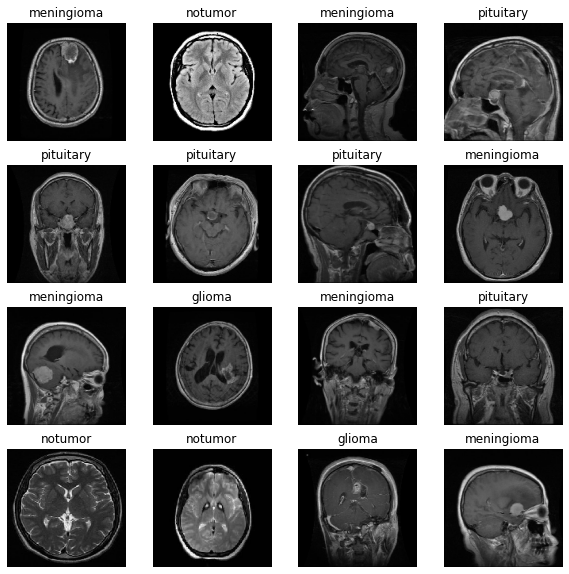

In [8]:
rows = 4 
columns = 4 
fig = plt.figure(figsize=(10, 10))
labels = ["glioma", "meningioma", "notumor", "pituitary"]

for i in range(1, rows*columns + 1):
    label_idx = train_ds[0][1][i].argmax()
    label = labels[label_idx]
    fig.add_subplot(rows, columns, i, title=label)
    plt.imshow(train_ds[0][0][i].astype("float32"))
    plt.axis("off")
    
plt.show()

# Basic Model

In [9]:
class ConvolutionBlock(ks.Model):
    def __init__(self, filters, kernel_size, dropout_rate, padding):
        super(ConvolutionBlock, self).__init__()
        self.conv = layers.Conv2D(filters, 
                                  kernel_size,
                                  padding=padding, 
                                  activation="relu")
        self.pool = layers.MaxPool2D(2, 2)
        self.norm = layers.BatchNormalization()
        self.drop = layers.Dropout(dropout_rate)
        
    def call(self, images):
        x = self.conv(images)
        x = self.pool(x)
        x = self.norm(x)
        x = self.drop(x)
        return x

In [10]:
inputs = layers.Input(shape=(150, 150, 3))
x = ConvolutionBlock(64, (3, 3), 0.3, "same")(inputs)
x = ConvolutionBlock(64, (3, 3), 0.3, "same")(x)
x = ConvolutionBlock(64, (3, 3), 0.3, "same")(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(4, activation="softmax")(x)

In [11]:
baisc_model = ks.models.Model(inputs, outputs)
baisc_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 convolution_block (Convolut  (None, 75, 75, 64)       2048      
 ionBlock)                                                       
                                                                 
 convolution_block_1 (Convol  (None, 37, 37, 64)       37184     
 utionBlock)                                                     
                                                                 
 convolution_block_2 (Convol  (None, 18, 18, 64)       37184     
 utionBlock)                                                     
                                                                 
 flatten (Flatten)           (None, 20736)             0         
                                                             

In [12]:
baisc_model.compile(loss=ks.losses.CategoricalCrossentropy(), 
              optimizer=ks.optimizers.Adam(learning_rate=1e-2), 
              metrics=["accuracy"])

In [13]:
checkpoint_filepath = 'best_weights_basic'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True)

In [14]:
history = baisc_model.fit(train_ds, epochs=25, batch_size=32, shuffle=True, validation_data=(test_ds), callbacks=[model_checkpoint_callback])

Epoch 1/25
45/45 [==============================] - 46s 933ms/step - loss: 9.4736 - accuracy: 0.3839 - val_loss: 4.1942 - val_accuracy: 0.2349
Epoch 2/25
45/45 [==============================] - 16s 352ms/step - loss: 1.1458 - accuracy: 0.4513 - val_loss: 1.7304 - val_accuracy: 0.2258
Epoch 3/25
45/45 [==============================] - 16s 355ms/step - loss: 1.0951 - accuracy: 0.4687 - val_loss: 1.7317 - val_accuracy: 0.3966
Epoch 4/25
45/45 [==============================] - 16s 355ms/step - loss: 0.9990 - accuracy: 0.5086 - val_loss: 7.1532 - val_accuracy: 0.4165
Epoch 5/25
45/45 [==============================] - 16s 360ms/step - loss: 0.9688 - accuracy: 0.5016 - val_loss: 1.1538 - val_accuracy: 0.4958
Epoch 6/25
45/45 [==============================] - 16s 351ms/step - loss: 0.9184 - accuracy: 0.5462 - val_loss: 1.3136 - val_accuracy: 0.4668
Epoch 7/25
45/45 [==============================] - 16s 354ms/step - loss: 0.8869 - accuracy: 0.5958 - val_loss: 1.0779 - val_accuracy: 0.5111

In [15]:
baisc_model.load_weights(checkpoint_filepath)

In [16]:
baisc_model.weights

[<tf.Variable 'convolution_block/conv2d/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
 array([[[[ 0.06379463, -0.13247412,  0.07685914, ...,  0.08735752,
           -0.14766867,  0.08394568],
          [-0.02829006, -0.15101133, -0.05087216, ..., -0.04384064,
           -0.10424277, -0.0407155 ],
          [ 0.05314596, -0.08540361,  0.01705664, ..., -0.03548437,
           -0.09011027, -0.00394888]],
 
         [[ 0.24600959,  0.25934955,  0.0234135 , ...,  0.07930761,
           -0.05049492,  0.00060525],
          [ 0.2565103 ,  0.06834295, -0.07634578, ...,  0.01697312,
           -0.10209323,  0.07501169],
          [ 0.2543049 ,  0.2143917 ,  0.03753345, ..., -0.00831621,
           -0.15572299,  0.03465356]],
 
         [[-0.11625293, -0.19290625, -0.0572075 , ..., -0.03379037,
           -0.08559339,  0.08044828],
          [-0.22205655, -0.17380986, -0.05672355, ...,  0.01670715,
           -0.02379828,  0.05513234],
          [-0.1958081 , -0.20430972,  0.03875728, ...,

# Transfer learning model 

In [17]:
base_net = ks.applications.MobileNetV2(weights="imagenet", 
                                       include_top=False)

In [18]:
base_net.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                            

In [19]:
inputs = layers.Input(shape=(150, 150, 3))
x = base_net(inputs)
x = ConvolutionBlock(64, (3, 3), 0.3, "same")(x)
x = ConvolutionBlock(64, (3, 3), 0.3, "same")(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(4, activation="softmax")(x)

In [20]:
transfer_model = ks.models.Model(inputs, outputs)
transfer_model.layers[1].trainable = False
transfer_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 convolution_block_3 (Convol  (None, 2, 2, 64)         737600    
 utionBlock)                                                     
                                                                 
 convolution_block_4 (Convol  (None, 1, 1, 64)         37184     
 utionBlock)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                           

                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 3,034,980
Trainable params: 776,740
Non-trainable params: 2,258,240
_________________________________________________________________


In [21]:
transfer_model.compile(loss=ks.losses.CategoricalCrossentropy(), 
              optimizer=ks.optimizers.Adam(learning_rate=1e-2), 
              metrics=["accuracy"])

In [22]:
checkpoint_filepath = 'best_weights_transfer'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True)

In [23]:
history = transfer_model.fit(train_ds, 
                    epochs=15, 
                    batch_size=32, 
                    shuffle=True, 
                    validation_data=(test_ds), 
                    callbacks=[model_checkpoint_callback])

Epoch 1/15
45/45 [==============================] - 19s 326ms/step - loss: 0.4936 - accuracy: 0.8097 - val_loss: 0.8968 - val_accuracy: 0.8215
Epoch 2/15
45/45 [==============================] - 12s 268ms/step - loss: 0.2735 - accuracy: 0.8960 - val_loss: 0.4736 - val_accuracy: 0.8528
Epoch 3/15
45/45 [==============================] - 12s 262ms/step - loss: 0.2017 - accuracy: 0.9228 - val_loss: 0.3180 - val_accuracy: 0.8947
Epoch 4/15
45/45 [==============================] - 12s 262ms/step - loss: 0.1399 - accuracy: 0.9492 - val_loss: 0.2664 - val_accuracy: 0.9146
Epoch 5/15
45/45 [==============================] - 12s 261ms/step - loss: 0.1246 - accuracy: 0.9536 - val_loss: 0.2646 - val_accuracy: 0.9169
Epoch 6/15
45/45 [==============================] - 12s 276ms/step - loss: 0.1035 - accuracy: 0.9641 - val_loss: 0.2548 - val_accuracy: 0.9184
Epoch 7/15
45/45 [==============================] - 13s 279ms/step - loss: 0.0901 - accuracy: 0.9702 - val_loss: 0.2217 - val_accuracy: 0.9420

In [24]:
transfer_model.load_weights(checkpoint_filepath)

In [25]:
transfer_model.evaluate(test_ds)

11/11 [==============================] - 2s 183ms/step - loss: 0.2283 - accuracy: 0.9535


[0.22830747067928314, 0.9534706473350525]

# ViT(vision transformer)

In [26]:
from vit_keras import vit

image_size = 224
model = vit.vit_b16(
    image_size=image_size,
    activation='softmax',
    pretrained=True,
    include_top=False,
    pretrained_top=False,
    classes=5
)

In [27]:
model.summary()

Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape (Reshape)           (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input   (None, 197, 768)         151296    
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 197, 768),       7087872   
 (TransformerBlock)           (None, 12, None, None))      

In [28]:
model.trainable = False

In [29]:
model.summary()

Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape (Reshape)           (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input   (None, 197, 768)         151296    
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 197, 768),       7087872   
 (TransformerBlock)           (None, 12, None, None))      

In [30]:
tf.keras.backend.clear_session()

inputs = layers.Input(shape=(150, 150, 3))
x = layers.Resizing(224, 224)(inputs)
x = model(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(4, activation="softmax")(x)
print(outputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), name='dense_1/Softmax:0', description="created by layer 'dense_1'")


In [31]:
vit_model = ks.models.Model(inputs, outputs)
vit_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 64)                49216     
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 85,848,132
Trainable params: 49,476
Non-trainab

In [32]:
vit_model.compile(loss=ks.losses.CategoricalCrossentropy(from_logits=False), 
              optimizer=ks.optimizers.Adam(learning_rate=1e-2), 
              metrics=["accuracy"])

In [33]:
checkpoint_filepath = 'best_weights_vit'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True)

In [34]:
history = vit_model.fit(train_ds, 
                    epochs=15, 
                    validation_data=(test_ds), 
                    callbacks=[model_checkpoint_callback])

Epoch 1/15
45/45 [==============================] - 261s 6s/step - loss: 0.8057 - accuracy: 0.7332 - val_loss: 0.5339 - val_accuracy: 0.7803
Epoch 2/15
45/45 [==============================] - 246s 5s/step - loss: 0.3245 - accuracy: 0.8759 - val_loss: 0.5439 - val_accuracy: 0.8139
Epoch 3/15
45/45 [==============================] - 246s 5s/step - loss: 0.2558 - accuracy: 0.8992 - val_loss: 0.4766 - val_accuracy: 0.8284
Epoch 4/15
45/45 [==============================] - 246s 5s/step - loss: 0.2337 - accuracy: 0.9149 - val_loss: 0.4173 - val_accuracy: 0.8505
Epoch 5/15
45/45 [==============================] - 243s 5s/step - loss: 0.2178 - accuracy: 0.9140 - val_loss: 0.4374 - val_accuracy: 0.8444
Epoch 6/15
45/45 [==============================] - 246s 5s/step - loss: 0.2032 - accuracy: 0.9237 - val_loss: 0.3225 - val_accuracy: 0.8848
Epoch 7/15
45/45 [==============================] - 243s 5s/step - loss: 0.2267 - accuracy: 0.9140 - val_loss: 0.3157 - val_accuracy: 0.8780
Epoch 8/15
45

In [35]:
vit_model.load_weights(checkpoint_filepath)
vit_model.evaluate(test_ds)

11/11 [==============================] - 49s 4s/step - loss: 0.2364 - accuracy: 0.9169


[0.2364492118358612, 0.9168573617935181]

# Model Selection

In [51]:
from sklearn.metrics import classification_report 
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix 
from sklearn.metrics import RocCurveDisplay

In [46]:
test_images = np.concatenate([test_ds[i][0] for i in range(test_ds.__len__())]) 
test_labels = np.concatenate([test_ds[i][1] for i in range(test_ds.__len__())]) 

In [47]:
test_labels = test_labels.argmax(axis=1)

In [48]:
print(f"shape of test images is {test_images.shape}")

shape of test images is (1311, 150, 150, 3)


In [49]:
print(f"shape of test labels is {test_labels.shape}")

shape of test labels is (1311,)


## basic model

In [53]:
conv_matrix_basic = confusion_matrix(test_labels, baisc_model.predict(test_images).argmax(axis=1))
conv_matrix_basic

41/41 [==============================] - 1s 21ms/step


array([[256,  21,   0,  23],
       [ 83, 141,  30,  52],
       [  2,  17, 375,  11],
       [ 10,   0,   0, 290]], dtype=int64)

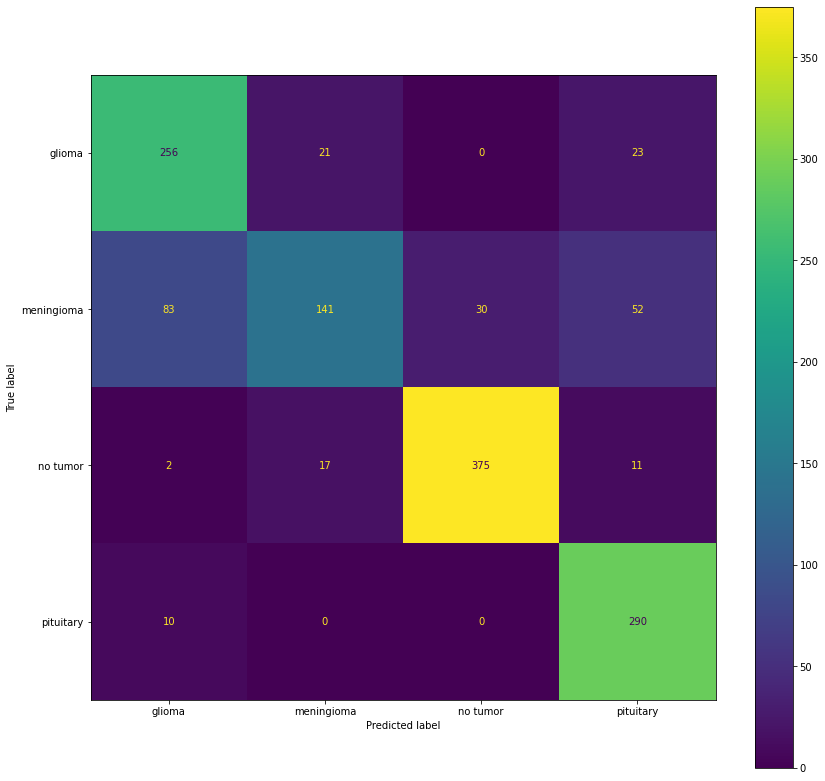

In [63]:
fig, ax = plt.subplots(figsize=(14, 14))
disp = ConfusionMatrixDisplay(confusion_matrix=conv_matrix_basic,
                               display_labels=["glioma", "meningioma", "no tumor", "pituitary"])
disp.plot(ax=ax)
plt.show()


In [64]:
print(classification_report(test_labels, baisc_model.predict(test_images).argmax(axis=1)))

41/41 [==============================] - 1s 24ms/step
              precision    recall  f1-score   support

           0       0.73      0.85      0.79       300
           1       0.79      0.46      0.58       306
           2       0.93      0.93      0.93       405
           3       0.77      0.97      0.86       300

    accuracy                           0.81      1311
   macro avg       0.80      0.80      0.79      1311
weighted avg       0.81      0.81      0.80      1311



# transfer learning model

In [65]:
conv_matrix_basic = confusion_matrix(test_labels, transfer_model.predict(test_images).argmax(axis=1))
conv_matrix_basic

41/41 [==============================] - 4s 56ms/step


array([[259,  33,   0,   8],
       [  3, 287,   2,  14],
       [  0,   0, 405,   0],
       [  1,   0,   0, 299]], dtype=int64)

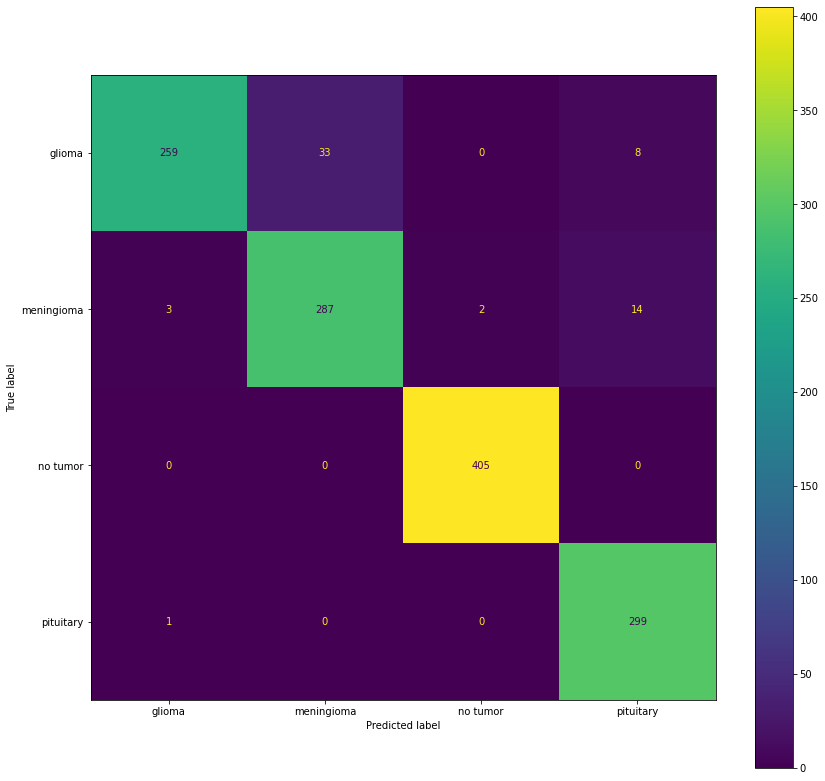

In [66]:
fig, ax = plt.subplots(figsize=(14, 14))
disp = ConfusionMatrixDisplay(confusion_matrix=conv_matrix_basic,
                               display_labels=["glioma", "meningioma", "no tumor", "pituitary"])
disp.plot(ax=ax)
plt.show()

In [68]:
print(classification_report(test_labels, transfer_model.predict(test_images).argmax(axis=1)))

41/41 [==============================] - 2s 54ms/step
              precision    recall  f1-score   support

           0       0.98      0.86      0.92       300
           1       0.90      0.94      0.92       306
           2       1.00      1.00      1.00       405
           3       0.93      1.00      0.96       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.96      0.95      0.95      1311



## ViT model 

In [69]:
conv_matrix_basic = confusion_matrix(test_labels, vit_model.predict(test_images).argmax(axis=1))
conv_matrix_basic

41/41 [==============================] - 52s 1s/step


array([[239,  48,   2,  11],
       [  5, 262,  15,  24],
       [  0,   0, 403,   2],
       [  1,   1,   0, 298]], dtype=int64)

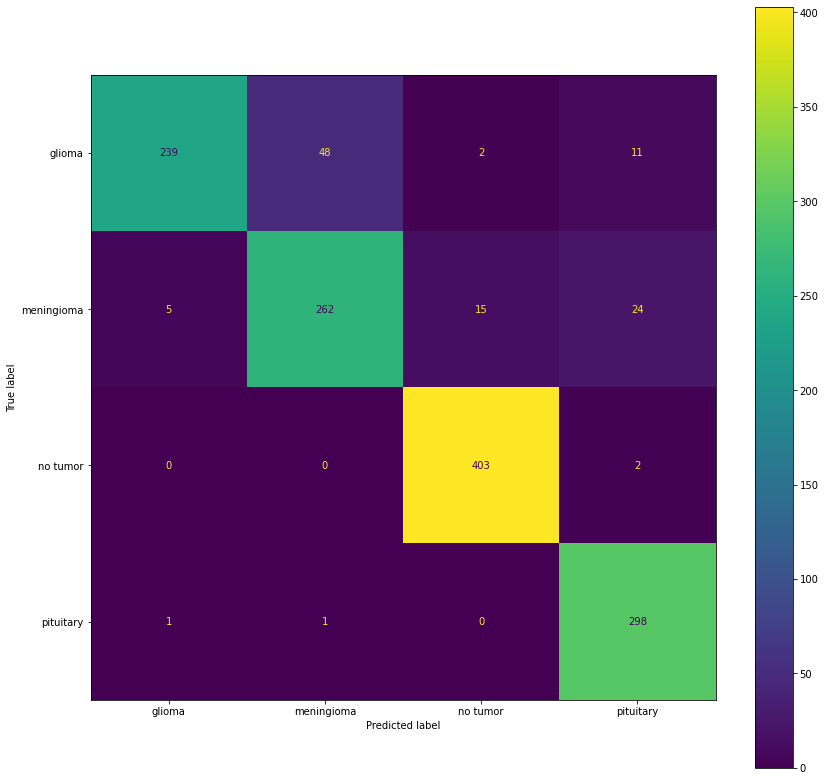

In [70]:
fig, ax = plt.subplots(figsize=(14, 14))
disp = ConfusionMatrixDisplay(confusion_matrix=conv_matrix_basic,
                               display_labels=["glioma", "meningioma", "no tumor", "pituitary"])
disp.plot(ax=ax)
plt.show()

In [72]:
print(classification_report(test_labels, vit_model.predict(test_images).argmax(axis=1)))

41/41 [==============================] - 50s 1s/step
              precision    recall  f1-score   support

           0       0.98      0.80      0.88       300
           1       0.84      0.86      0.85       306
           2       0.96      1.00      0.98       405
           3       0.89      0.99      0.94       300

    accuracy                           0.92      1311
   macro avg       0.92      0.91      0.91      1311
weighted avg       0.92      0.92      0.92      1311



In [73]:
transfer_model.save("deployment_model")

INFO:tensorflow:Assets written to: deployment_model\assets


INFO:tensorflow:Assets written to: deployment_model\assets
